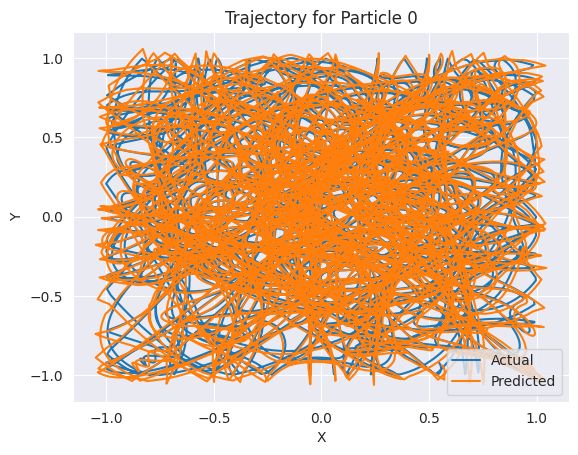

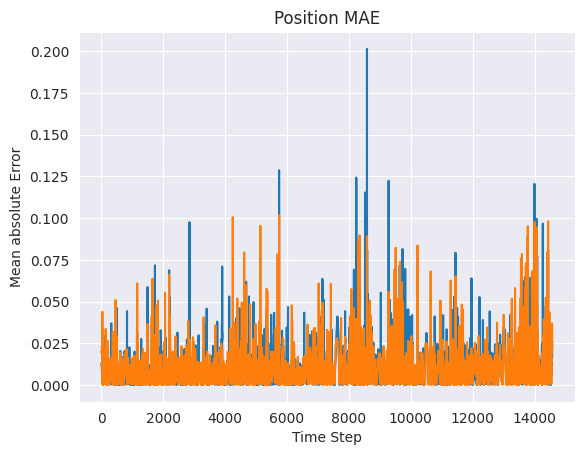

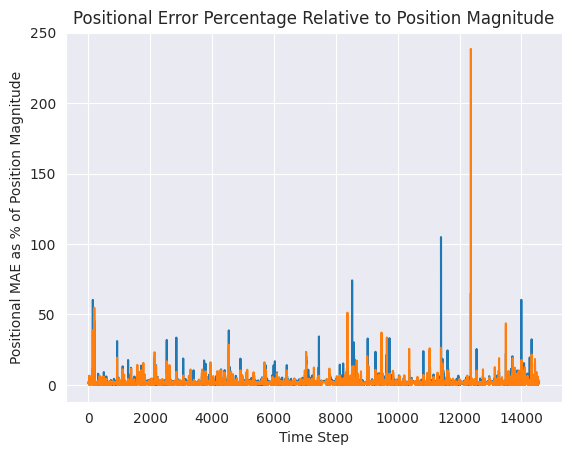

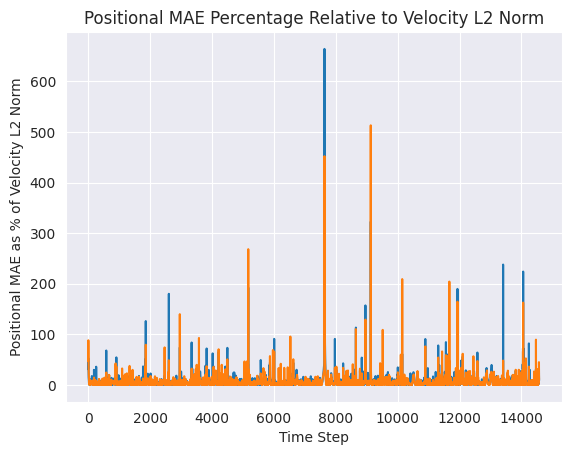

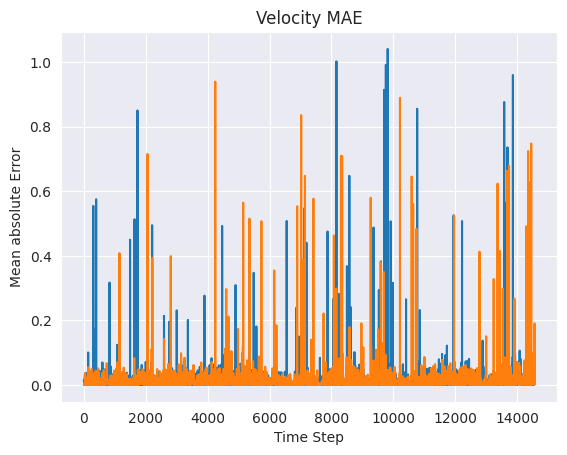

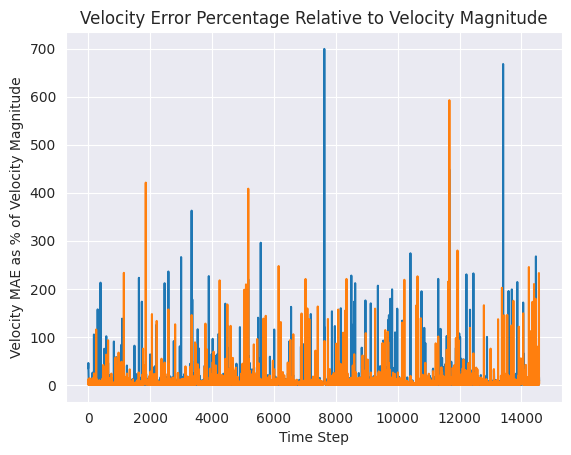

In [1]:
%matplotlib inline
import numpy as np
import torch
import utils as ut
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import os
from datetime import datetime
import glob

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#run = os.path.join("runs_gravity_one_particle", "p_2023-11-28 12:16_l1_256_4_1_32_1e-05")
run = os.path.join("runs_g_1p_encoder_mlp",
                   #"relu_2023-12-03 12:26_l1_256_4_1_32_0.001_double_2_(256, 256, 256, 256)_Tanh_mlponinput")
                   #"relu_2023-12-04 11:57_l1_256_4_1_32_0.001_double_2_(256, 256, 256, 256)_Tanh_mlponinput_nonorm")
                   #"relu_2023-12-05 16:13_l1_256_4_1_32_0.001_double_2_(256, 256, 256, 256)_Tanh_mlpoutput")
                   "relu_2023-12-08 10:24_l1_512_4_1_32_0.001_double_2_(512, 512, 512)_Tanh_mlpoutput")

models = glob.glob(run + "/" + '*.pth')
if len(models) > 1:
    print("MORE MODELS FOUND IN THE DIR, LOADING THE FIRST:", models[0])

model = torch.load(models[0])
particle_index = model.particle_index
particle_dim = model.hparams.get("particle_dim")
boxSize = model.hparams.get("boxSize")
dims = int(particle_dim / 2)

data = np.load(os.path.join(run, "data_arrays.npz"))
inputs_np = data['inputs']
targets_np = data['targets']

inputs_tensor = torch.tensor(inputs_np, dtype=torch.float64).to(device)
targets_tensor = torch.tensor(targets_np, dtype=torch.float64).to(device)
predicted_data = ut.get_predicted_data(model, inputs_tensor, particle_index)

ut.plot_trajectory(targets_np, predicted_data, particle_index=particle_index, dims=dims)
ut.plot_error_over_time_position(targets_np, predicted_data, particle_index, dims=dims)
ut.plot_error_over_time_velocity(targets_np, predicted_data, particle_index, dims=dims)

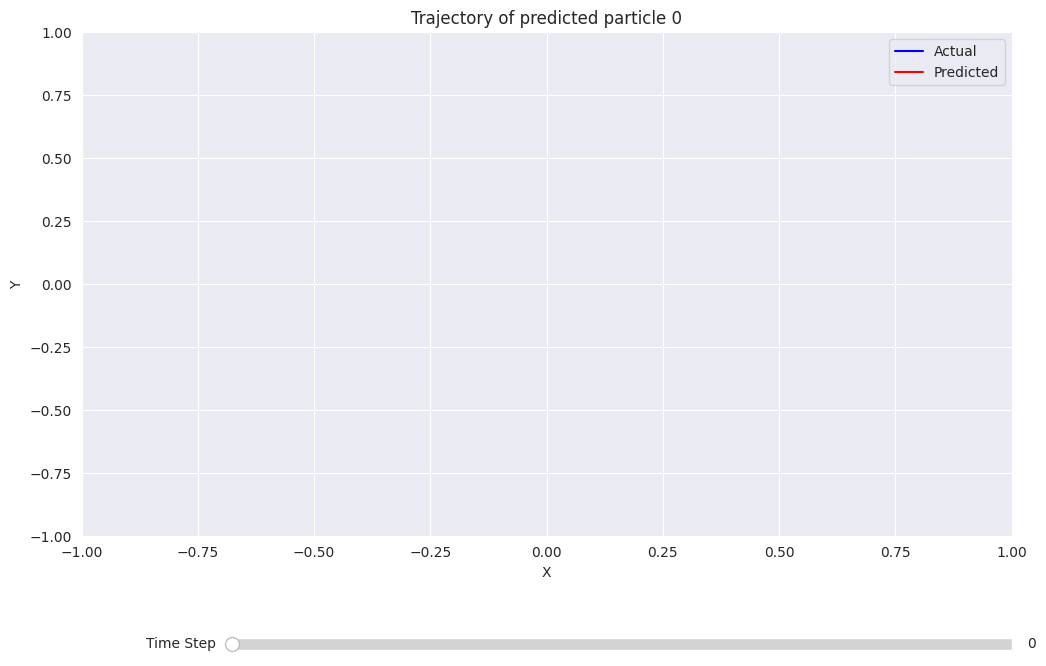

In [2]:
ut.interactive_trajectory_plot(targets_np, predicted_data, particle_index=particle_index, boxSize=boxSize, dims=dims)

In [3]:
ut.interactive_trajectory_plot_all_particles(targets_np[0:1000, ...], predicted_data[0:1000, ...], particle_index,
                                             boxSize=boxSize, dims=dims, offline_plot=True)

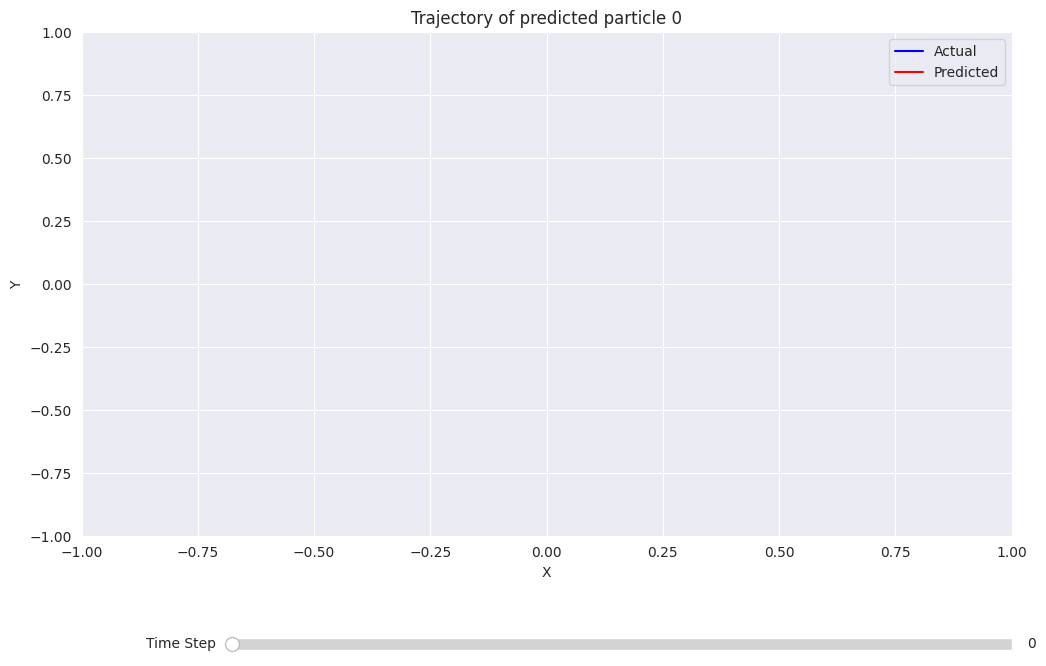

In [4]:
number_of_predictions = 2000
reset_every = 120

predicted_data_self_feed = ut.self_feed(model, inputs_tensor, number_of_predictions=number_of_predictions,
                                        reset_every=reset_every)
fig = ut.interactive_trajectory_plot(targets_np[:number_of_predictions, :, :], predicted_data_self_feed, particle_index,
                                     dims=dims)

In [5]:
ut.interactive_trajectory_plot_all_particles(targets_np[:number_of_predictions, :, :], predicted_data_self_feed,
                                             particle_index, dims=dims)

In [6]:
# import importlib
# importlib.reload(ut)
# %matplotlib qt
# ut.interactive_trajectory_plot_just_sim(inputs_np, particle_index=None, boxSize=boxSize, dims=dims)

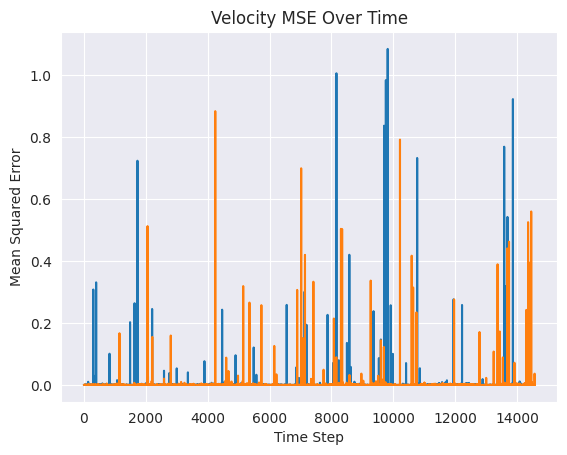

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
if particle_index is not None:

    actual_data = targets_np[:, particle_index, :].reshape(-1, 1, 2 * dims)
else:
    actual_data = targets_np

mse_values = ut.calculate_mse(actual_data[:, :, dims:],
                           predicted_data[:, :, dims:])  # Considering only position data for MSE
time_steps = np.arange(mse_values.shape[0])  # Generate an array of time steps
plt.figure()
plt.plot(time_steps, mse_values)  # Plot MSE values against time steps
plt.xlabel('Time Step')
plt.ylabel('Mean Squared Error')
plt.title('Velocity MSE Over Time')
plt.show()

In [8]:
# high_error_indices = np.where(mse_values > 30)[0]
# for t in high_error_indices:
#     print(f"Time Step: {t}")
#     print("Target Data:", targets_np[t])
#     print("Input Data:", inputs_np[t])
#     print("Actual Data:", actual_data[t])
#     print("MSE:", mse_values[t])
#     print("-" * 50)

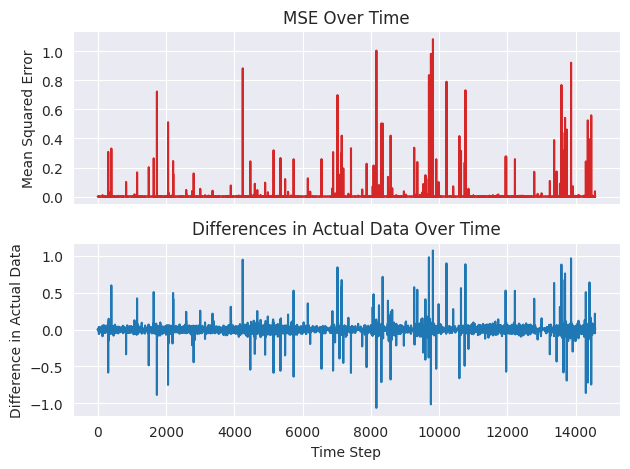

In [9]:
%matplotlib inline
actual_data_diff = np.diff(actual_data[:,0,:], axis=0)
# Time steps for the actual data differences
time_steps_diff = np.arange(actual_data_diff.shape[0])

# Create two subplots with shared x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

# Plotting the MSE values in the first subplot
ax1.plot(time_steps, mse_values, color='tab:red')
ax1.set_ylabel('Mean Squared Error')
ax1.set_title('MSE Over Time')

# Plotting the differences in actual data in the second subplot
ax2.plot(time_steps_diff, actual_data_diff, color='tab:blue')
ax2.set_xlabel('Time Step')
ax2.set_ylabel('Difference in Actual Data')
ax2.set_title('Differences in Actual Data Over Time')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

Correlation coefficient between minimum distance to bounding box edge and MSE: -0.09931454773502146


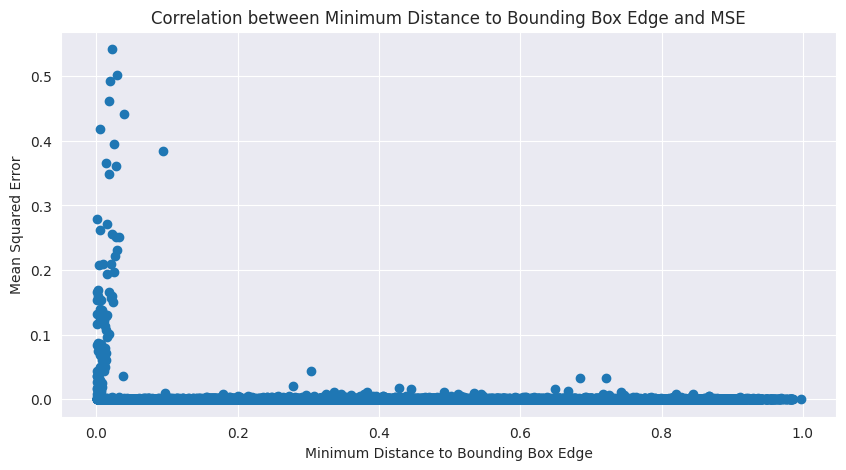

In [10]:
%matplotlib inline
import scipy.stats as stats

position_data = actual_data[:, 0, :dims]
# Calculate the minimum absolute distance of each position to the nearest bounding box edge
# The bounding box edges are at -1 and 1 for both axes
distances_to_edge_x = np.minimum(np.abs(position_data[:, 0] + 1), np.abs(position_data[:, 0] - 1))
distances_to_edge_y = np.minimum(np.abs(position_data[:, 1] + 1), np.abs(position_data[:, 1] - 1))

# Combining the distances to find the closest distance to any edge
min_distances_to_edge = np.minimum(distances_to_edge_x, distances_to_edge_y)

# Ensure mse_values is a 1D array
# If mse_values is multi-dimensional, you might need to adjust this part
if len(mse_values.shape) > 1:
    mse_values = np.mean(mse_values, axis=1)

# Calculate correlation
correlation_coefficient, _ = stats.pearsonr(min_distances_to_edge, mse_values)

# Print correlation coefficient
print(f"Correlation coefficient between minimum distance to bounding box edge and MSE: {correlation_coefficient}")

# Optionally, plot this relationship
plt.figure(figsize=(10, 5))

# Plotting minimum distance to bounding box edge vs MSE
plt.scatter(min_distances_to_edge, mse_values)
plt.xlabel('Minimum Distance to Bounding Box Edge')
plt.ylabel('Mean Squared Error')
plt.title('Correlation between Minimum Distance to Bounding Box Edge and MSE')
plt.grid(True)

plt.show()

Correlation coefficient between distance from starting point and MSE: 0.09480212942855146


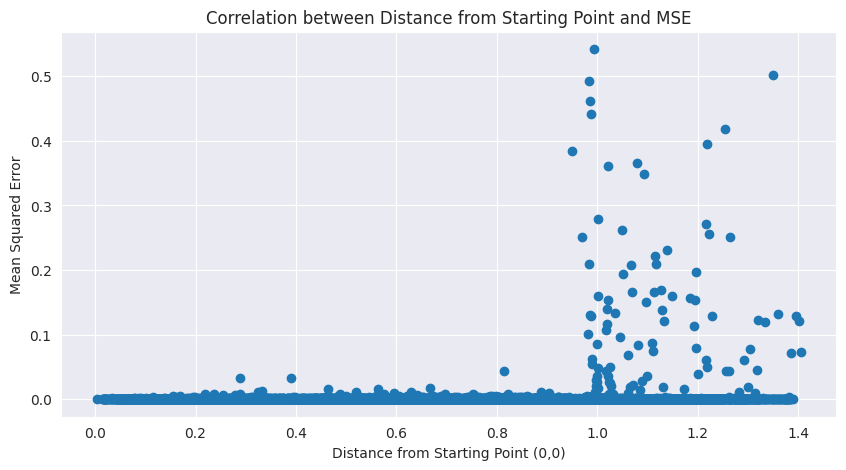

In [11]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Assuming dims, actual_data, and mse_values are defined

# Extract position data
position_data = actual_data[:, 0, :dims]

# Calculate the Euclidean distance of each position from the point (0,0)
distances_from_start = np.linalg.norm(position_data, axis=1)

# Ensure mse_values is a 1D array
# If mse_values is multi-dimensional, you might need to adjust this part
if len(mse_values.shape) > 1:
    mse_values = np.mean(mse_values, axis=1)

# Calculate correlation
correlation_coefficient, _ = stats.pearsonr(distances_from_start, mse_values)

# Print correlation coefficient
print(f"Correlation coefficient between distance from starting point and MSE: {correlation_coefficient}")

# Optionally, plot this relationship
plt.figure(figsize=(10, 5))

# Plotting distance from starting point vs MSE
plt.scatter(distances_from_start, mse_values)
plt.xlabel('Distance from Starting Point (0,0)')
plt.ylabel('Mean Squared Error')
plt.title('Correlation between Distance from Starting Point and MSE')
plt.grid(True)

plt.show()


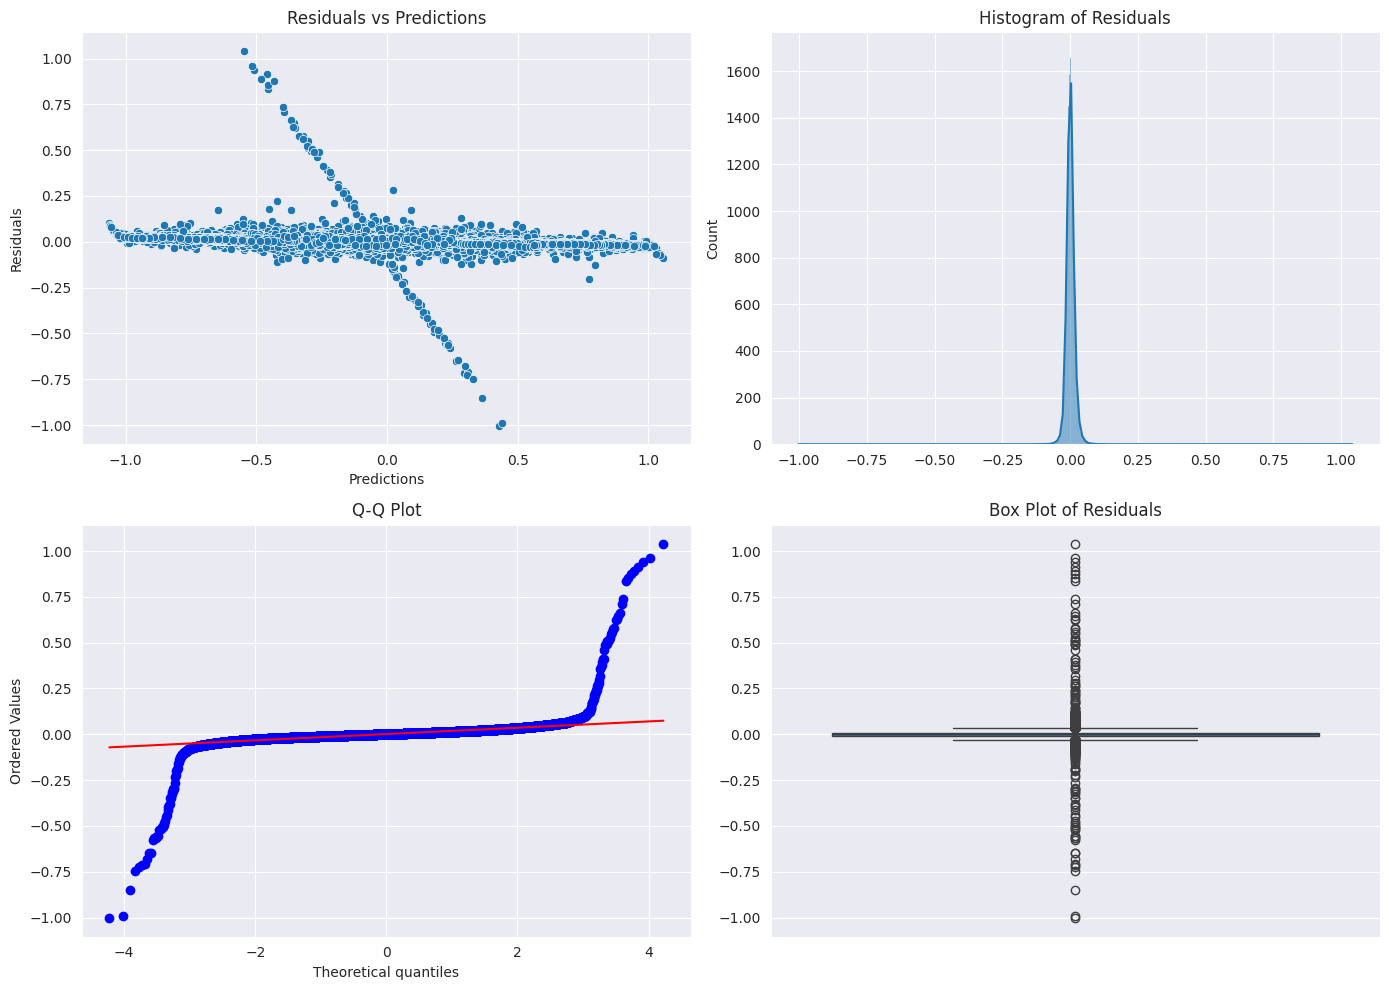

/home/mightycarrot/anaconda3/envs/n_body_approx/lib/python3.8/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.0014912418898194264,
 0.02600723371695674,
 ShapiroResult(statistic=0.4384129047393799, pvalue=0.0))

In [12]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Assuming 'outputs' and 'targets' are already defined as torch tensors
# Calculate residuals
outputs = predicted_data[:,0,:]
residuals = targets_np[:, particle_index, :] - outputs

# Convert residuals to a numpy array for visualization and analysis
residuals_np = residuals

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Residuals vs Predictions plot
sns.scatterplot(x=outputs.flatten(), y=residuals_np.flatten(), ax=axes[0, 0])
axes[0, 0].set_title('Residuals vs Predictions')
axes[0, 0].set_xlabel('Predictions')
axes[0, 0].set_ylabel('Residuals')

# Histogram of residuals
sns.histplot(residuals_np.flatten(), kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Histogram of Residuals')

# Q-Q plot for normality check
stats.probplot(residuals_np.flatten(), dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot')

# Box plot for outlier analysis
sns.boxplot(data=residuals_np.flatten(), ax=axes[1, 1])
axes[1, 1].set_title('Box Plot of Residuals')

plt.tight_layout()
plt.show()

# Statistical Analysis
mean_residuals = residuals_np.mean()
std_residuals = residuals_np.std()
shapiro_test = stats.shapiro(residuals_np.flatten())

# Print statistical analysis results
(mean_residuals, std_residuals, shapiro_test)


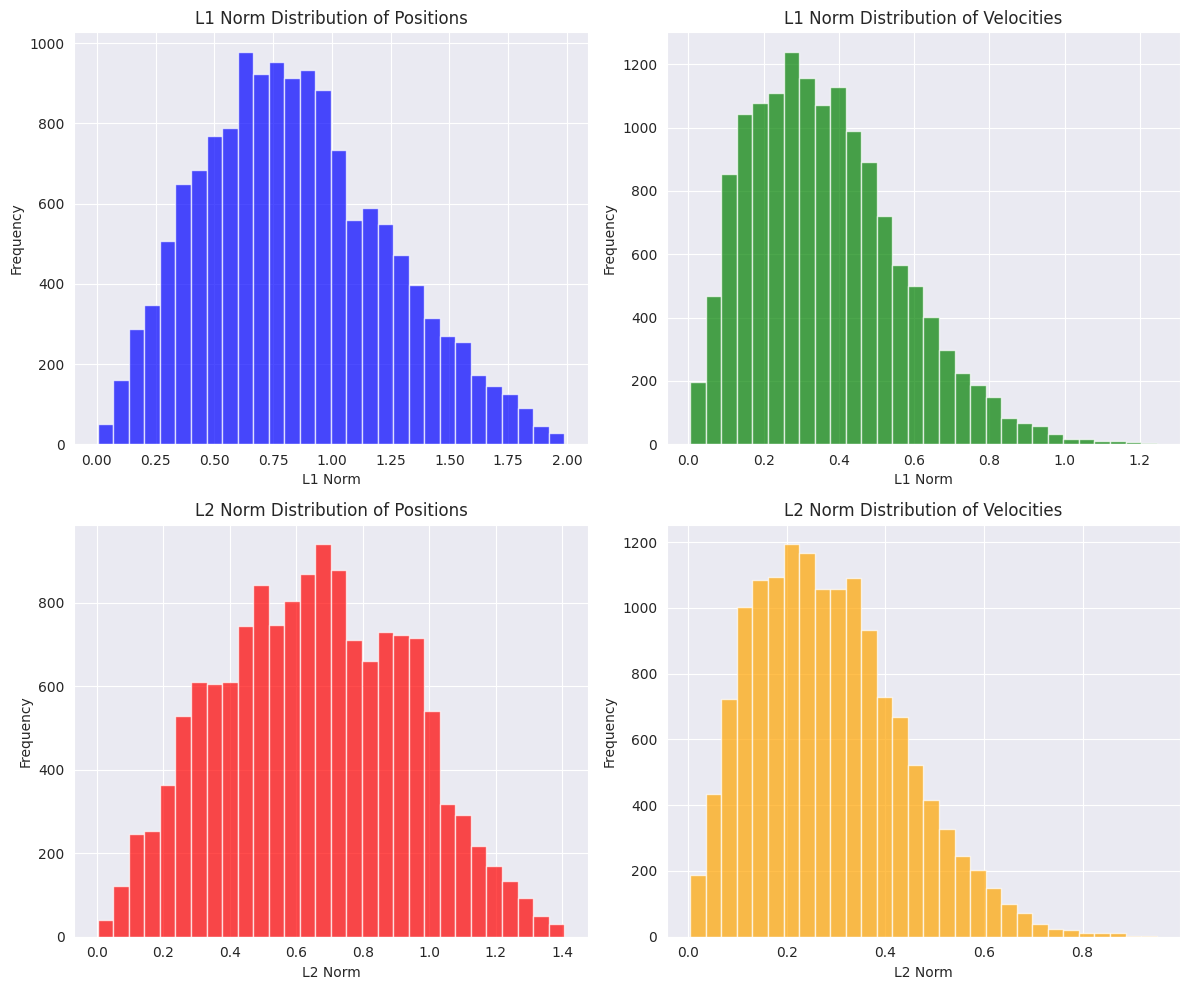

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming dims, actual_data are defined
# Extract position and velocity data
position_data = actual_data[:, :, :dims]
velocity_data = actual_data[:, :, dims:]

# Calculate L1 (Manhattan) and L2 (Euclidean) norms for positions and velocities
l1_norm_positions = np.sum(np.abs(position_data), axis=2)
l2_norm_positions = np.linalg.norm(position_data, axis=2)

l1_norm_velocities = np.sum(np.abs(velocity_data), axis=2)
l2_norm_velocities = np.linalg.norm(velocity_data, axis=2)

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# L1 Norms
axes[0, 0].hist(l1_norm_positions.flatten(), bins=30, alpha=0.7, color='blue')
axes[0, 0].set_title('L1 Norm Distribution of Positions')
axes[0, 0].set_xlabel('L1 Norm')
axes[0, 0].set_ylabel('Frequency')

axes[0, 1].hist(l1_norm_velocities.flatten(), bins=30, alpha=0.7, color='green')
axes[0, 1].set_title('L1 Norm Distribution of Velocities')
axes[0, 1].set_xlabel('L1 Norm')
axes[0, 1].set_ylabel('Frequency')

# L2 Norms
axes[1, 0].hist(l2_norm_positions.flatten(), bins=30, alpha=0.7, color='red')
axes[1, 0].set_title('L2 Norm Distribution of Positions')
axes[1, 0].set_xlabel('L2 Norm')
axes[1, 0].set_ylabel('Frequency')

axes[1, 1].hist(l2_norm_velocities.flatten(), bins=30, alpha=0.7, color='orange')
axes[1, 1].set_title('L2 Norm Distribution of Velocities')
axes[1, 1].set_xlabel('L2 Norm')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()